# __9.1 Wrap up analysis__

Goal:
- Tie the loose ends

## ___Setup___

### Module import

In conda env `base`

In [5]:
import pickle
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import statsmodels.api as sm
from pathlib import Path
from scipy.optimize import curve_fit
from scipy.interpolate import interp1d
from scipy.misc import derivative
from scipy.stats import ttest_1samp
from datetime import datetime
from tqdm import tqdm
from bisect import bisect
from collections import OrderedDict
from sklearn.metrics import mean_squared_error

### Key variables

In [3]:
# Reproducibility
seed = 20220609

# Setting working directory
proj_dir   = Path.home() / "projects/plant_sci_hist"
work_dir   = proj_dir / "9_wrap_up"
work_dir.mkdir(parents=True, exist_ok=True)

# text classify
dir2 =  proj_dir / "2_text_classify"

# plant science corpus with topic assignment info
dir42      = proj_dir / "4_topic_model/4_2_outlier_assign"
corpus_file = dir42 / "table4_2_corpus_with_topic_assignment.tsv.gz"
#corpus_file = dir42 / "test.tsv"

dir43 = proj_dir / "4_topic_model/4_3_model_analysis"

# over time
dir44         = proj_dir / "4_topic_model/4_4_over_time"
dir_lowess    = dir44 / "_lowess"
top_freq_file = dir44 / 'table4_4c_topic_frequency_per_timestamp.txt'
ts_for_bins_file = dir44 / "table4_4_bin_timestamp_date.tsv"

# Species info
dir51 = proj_dir / "5_species_over_time/5_1_sp_time"
genus_count_file = dir51 / "Table_5_1_genus-of-viridiplantae_top20_count_ts_bins.txt"

# Arabidopsis
dir6              = proj_dir / "6_topic_model_arabidopsis/"
corpus_target_file = dir6 / "corpus_arabidopsis.tsv.gz"

# country info, pmid, ...
dir75             = proj_dir / "7_countries/7_5_country_over_time"
ci_file           = dir75 / 'ci_pmid_topic.tsv'
c_npub_file       = dir75 / 'country_npub_raw.csv'
t25_toc_stat_file = dir75 / "country_top25_toc_stat.csv"

# SJR and pdjity (pmid, date, journal, issn, topic, year)
dir81            = proj_dir / '8_impact/8_1_topic'
pdjity_file      = dir81 / "table_pdjity.tsv"
file_d_d_metric  = dir81 / 'sjr_metric_dicts.pkl'

# So PDF is saved in a format properly
mpl.rcParams['pdf.fonttype'] = 42
plt.rcParams["font.family"] = "sans-serif"

## ___Finalize pub number graphs___

### Pub number graph after removing China

Related graphs:
- 1_1: number pubs per year in pubmed
- 4_4: number pubs per year in plant science corpus

Focus on 1951 to 2020

In [16]:
file_docs_year_df = dir44 / "table_4_4_docs_year_df.csv"
docs_year_df = pd.read_csv(file_docs_year_df, index_col=0).drop(2021)
docs_year_df.iloc[-2:]

,Count
2019,26963
2020,30228


In [21]:
# Get pub number for CHN
file_c25_year_count = dir75 / "country_top25_year_count.csv"
c25_year_count = pd.read_csv(file_c25_year_count, index_col=0)
pub_num_CHN    = c25_year_count.loc["CHN"]

# convert to dictionary, note that the indices are strings, need to be integer
pub_num_CHN_dict = {int(k):v for k,v in pub_num_CHN.items()}

pub_num_CHN['2019'], pub_num_CHN_dict[2019]

(7869, 7869)

In [15]:
# add missing years
pub_num_CHN_list = []
for yr in docs_year_df.index:
  if yr in pub_num_CHN_dict:
    pub_num_CHN_list.append(pub_num_CHN_dict[yr])
  else:
    pub_num_CHN_list.append(0)

docs_year_df.shape, len(pub_num_CHN_list)

((96, 2), 96)

In [17]:
### Substract CHN from total then add to df 
docs_year_df["CHN"] = pub_num_CHN_list
docs_year_df.head(2)

,Count,CHN
1917,1,0
1918,1,0


In [20]:
docs_year_df['Count_no_CHN'] = docs_year_df['Count'] - docs_year_df['CHN']
docs_year_df.head(2), docs_year_df.tail(2)

(      Count  CHN  Count_no_CHN
 1917      1    0             1
 1918      1    0             1,
       Count   CHN  Count_no_CHN
 2019  26963  7869         19094
 2020  30228  9031         21197)

In [27]:
target_yrs = [y for y in range(1951, 2021)]

docs_year_df_part = docs_year_df.loc[target_yrs]
docs_year_df_part.head(2), docs_year_df_part.tail(2)

(      Count  CHN  Count_no_CHN
 1951      2    0             2
 1952      2    0             2,
       Count   CHN  Count_no_CHN
 2019  26963  7869         19094
 2020  30228  9031         21197)

In [28]:
### Plot exponential fit

X = docs_year_df_part.index
Y = docs_year_df_part["Count_no_CHN"].values

def exp_func(X, a, b, c):
  return a*np.exp(b*X) + c

# Curve fit
popt_exp, _ = curve_fit(exp_func, X, Y, p0=(1, 1e-6, 1), maxfev=10000)
popt_exp

array([ 1.97174697e-41,  5.13730308e-02, -1.24134120e+03])

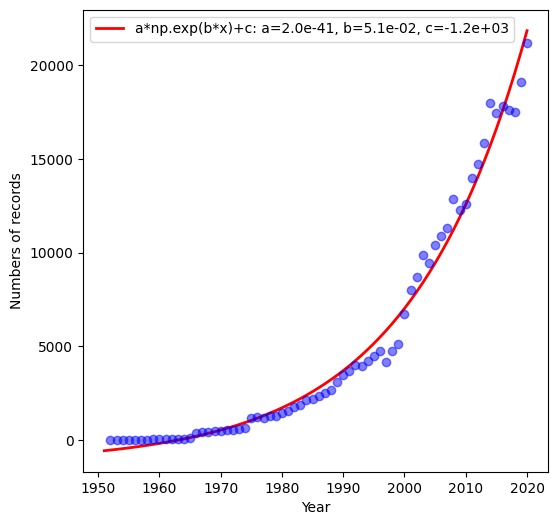

In [30]:
# Plotting
fig_fit_yr_docnum = work_dir / "fig_9_year_docnum_noCHN_exponential_fit.pdf"

#y_pred = [exp_func(x, *popt_exp) for x in X]
plt.figure(figsize=(6, 6))

# plot legend in scientific number:
#https://www.scaler.com/topics/python-scientific-notation/
#https://sparrow.dev/python-scientific-notation/

plt.plot(X, exp_func(X, *popt_exp),'r',linewidth=2, 
        label='a*np.exp(b*x)+c: a=%.1e, b=%.1e, c=%.1e' % tuple(popt_exp))
plt.plot(X[1:], Y[1:], 'bo', alpha=0.5)
#plt.plot(x[1:], y_pred[1:], '-b')
plt.legend()
plt.xlabel("Year")
plt.ylabel("Numbers of records")
plt.savefig(fig_fit_yr_docnum, format='pdf')
plt.show()

## ___Table S1___

Turn out_raw_journal_counts into a table

In [38]:
jcount_file = dir2 / "out_raw_journal_counts"
jcount_tsv  = dir2 / "out_raw_journal_counts.tsv"

In [40]:
jcount_file

PosixPath('/home/shius/projects/plant_sci_hist/2_text_classify/out_raw_journal_counts')

In [43]:
# Split based on the last "," then output as a file
jcount_list = []
with open(jcount_file) as f:
  jcounts = f.readlines()
  for jc in jcounts:
    j = jc[:jc.rfind(",")]
    c = jc[jc.rfind(",")+1:]
    jcount_list.append([j,c])

with open(jcount_tsv, "w") as f:
  for jc in jcount_list:
    f.write(jc[0] + "\t" + jc[1])


## ___Chosing articles for select topic in specific years___

### Read corpus with topiv assignment

In [8]:
corpus_df = pd.read_csv(corpus_file, sep='\t', compression='gzip', index_col=0)

In [9]:
corpus_df.head(2)

,Index_1385417,PMID,Date,Journal,Title,Abstract,Initial filter qualifier,Corpus,reg_article,Text classification score,Preprocessed corpus,Topic
0,3,61,1975-12-11,Biochimica et biophysica acta,Identification of the 120 mus phase in the dec...,After a 500 mus laser flash a 120 mus phase in...,spinach,Identification of the 120 mus phase in the dec...,1,0.716394,identification 120 mus phase decay delayed flu...,52
1,4,67,1975-11-20,Biochimica et biophysica acta,Cholinesterases from plant tissues. VI. Prelim...,Enzymes capable of hydrolyzing esters of thioc...,plant,Cholinesterases from plant tissues. VI. Prelim...,1,0.894874,cholinesterases plant tissues . vi . prelimina...,48


In [22]:
# Add the year column
dates = corpus_df.Date.values
years = [int(date.split('-')[0]) for date in dates]

corpus_df["Year"] = years

### Function to get specific topic/year range dataframe

In [57]:
def get_df_toc_years(df, toc, y_begin, y_end):
  '''
  Args:
    df (pd.DataFrame): corpus_df with Year column
    toc (dict): table of contents
    y_begin (int): begin year, inclusive
    y_end (int): end year, inclusive
  Output:
    df_toc_years (csv)
  '''

  cond1 = corpus_df['Topic'] == toc
  cond2 = corpus_df['Year'].isin(range(y_begin, y_end+1))

  df_toc_years =  corpus_df[cond1 & cond2]

  df_toc_years.to_csv(work_dir / f'table_9_corpus_toc{toc}_yr{y_begin}-{y_end}.csv', 
                      index=False)

  return df_toc_years


### Topic 78, year 1998, 1999, 2000

In [58]:
df_toc78 = get_df_toc_years(corpus_df, 78, 2000, 2002)
df_toc78.shape

(103, 13)

### Topic 44, year 1917-1977

In [60]:
df_toc44 = get_df_toc_years(corpus_df, 44, 1917, 1977)
df_toc44.shape

(1223, 13)

## ___Major down/up-ward trends per time point___

Prior and current work on this
- In section 4_4c
  - I have played with quite a few different ways to predict trends.
  - But the predicted trend lines looks suspicious and unexpected so did not adopt them.
  - End up using Lowess fit.
- In section 4_4d
  - I have further picked the best fiting lowess models for each topic.
  - The fit is saved as pickle for each topic.
  - Have experimented with ways to define major transition. But at the time, I tried to do this per topic and encountered issues with topics that have multiple peaks.
- Once I finished discussing Figure 3 
  - Realize that there are 3 major transitions:
  - Also realize that I should have a measure to estimate "transition".

Define transition point: 
- time points with among the highest degree of 
  - downward trend
  - upward trend
- In both cases, use the 1st derivative of lowess fit at that time point as measure for trend
  - Ignore outlier (-1)
  - Separate positive and negative values for up and downward trends, respectively.
  - [Not done] Set a threshold and get the average of slopes above threshold
    - Want to ignore slopes ~0 because they only make the sum look smaller than it really is.
    - Turn on that this is not straightforward. No clear way to set threshold.
  - Generate averaged sums of 1st derivative values for up and down-ward trends based on the number of positive and negative values, respectively.

For getting slope:
- https://stackoverflow.com/questions/30309557/how-to-get-derivatives-from-1d-interpolation




### Read relevant files

In [4]:
# Load topic frequency for each timestamp
top_freq_df = pd.read_csv(top_freq_file, index_col=0)
topics      = top_freq_df.index.tolist()              # topic list
toc_series  = top_freq_df.loc[0]                      # topic frequency series
                                                      # same for all topics
ts_list     = [float(ts) for ts in toc_series.index]  # timestamps
ts0 = ts_list[0]                                      # first timestamp
ts1 = ts_list[-1]                                     # last timestamp

# Start from 1978 to 2020
datetime.fromtimestamp(ts0), datetime.fromtimestamp(ts1)

(datetime.datetime(1977, 12, 11, 23, 59, 59),
 datetime.datetime(2021, 1, 1, 0, 0))

In [5]:
# Get lowess pickles
lowess_pickles = list(dir_lowess.glob('**/*.pickle'))
lowess_pickles

[PosixPath('/home/shinhan/projects/plant_sci_hist/4_topic_model/4_4_over_time/_lowess/lowess_fit_func_topic-1_frac0.1.pickle'),
 PosixPath('/home/shinhan/projects/plant_sci_hist/4_topic_model/4_4_over_time/_lowess/lowess_fit_func_topic-1_frac0.2.pickle'),
 PosixPath('/home/shinhan/projects/plant_sci_hist/4_topic_model/4_4_over_time/_lowess/lowess_fit_func_topic-1_frac0.3.pickle'),
 PosixPath('/home/shinhan/projects/plant_sci_hist/4_topic_model/4_4_over_time/_lowess/lowess_fit_func_topic0_frac0.1.pickle'),
 PosixPath('/home/shinhan/projects/plant_sci_hist/4_topic_model/4_4_over_time/_lowess/lowess_fit_func_topic0_frac0.2.pickle'),
 PosixPath('/home/shinhan/projects/plant_sci_hist/4_topic_model/4_4_over_time/_lowess/lowess_fit_func_topic0_frac0.3.pickle'),
 PosixPath('/home/shinhan/projects/plant_sci_hist/4_topic_model/4_4_over_time/_lowess/lowess_fit_func_topic10_frac0.1.pickle'),
 PosixPath('/home/shinhan/projects/plant_sci_hist/4_topic_model/4_4_over_time/_lowess/lowess_fit_func_topic

### Get derivatives

In [15]:
# derivative(f, x0, dx) = (f(x0+dx) - f(x0-dx)) / (2 * dx)
# dx is set to 1 week = 7*24*60*60 seconds
dx = 7*24*60*60 

# Create {topic: {frac_param: {year: slope}}} for record-keeping
toc_slopes = {}

# {frac: topic: {year: slope}}
fp_slopes = {} 

# Create {year: {frac_param: [slopes]}} to detect shifts
yr_slopes = {}

# For each topic
for pkl in lowess_pickles:
  # file name: lowess_fit_func_topicX_fracX.X.pickle
  f_name = str(pkl).split("/")[-1]
  # get topic index
  topic = f_name.split("_")[3][5:]
  # get fraction parameter
  frac = f_name.split("_")[4].split(".pickle")[0][4:]

  # skip outlier
  if topic == '-1':
    continue

  if topic not in toc_slopes:
    toc_slopes[topic] = {frac: {}}
  else:
    toc_slopes[topic][frac] = {}

  if frac not in fp_slopes:
    fp_slopes[frac] = {topic: {}}
  else:
    fp_slopes[frac][topic] = {}

  # Checked and confirmed that the topic and frac are correct
  #print(f_name, topic, frac)

  # read lowess fit
  with open(pkl, 'rb') as f:
    lowess_fit = pickle.load(f)


  # Start from 1978 to 2020, do it every year
  for yr in range(1978, 2021):
    x0 = datetime(yr, 1, 1).timestamp()
    # Slope very small because the scale for x is very large compare to y
    slope =  derivative(lowess_fit, x0, dx)

    toc_slopes[topic][frac][yr] = slope
    fp_slopes[frac][topic][yr]  = slope

    if yr not in yr_slopes:
      yr_slopes[yr] = {frac: [slope]}
    elif frac not in yr_slopes[yr]:
      yr_slopes[yr][frac] = [slope]
    else:
      yr_slopes[yr][frac].append(slope)

In [16]:
# Save toc_slopes and year_slopes as pickles
with open(work_dir / 'dict_toc_frac_year_lowess_slopes.pkl', 'wb') as f:
  pickle.dump(toc_slopes, f)

# Save toc_slopes and year_slopes as pickles
with open(work_dir / 'dict_frac_toc_year_lowess_slopes.pkl', 'wb') as f:
  pickle.dump(fp_slopes, f)

with open(work_dir / 'dict_year_frac_lowess_slopes.pkl', 'wb') as f:
  pickle.dump(yr_slopes, f)

### df_slope_sum output dataframe

In [17]:
# Create a dataframe with yr_slope_sum, 7 columns:
#  year
#  frac_param_0.1_positive
#  frac_param_0.2_positive
#  frac_param_0.3_positive
#  frac_param_0.1_negative
#  frac_param_0.2_negative
#  frac_param_0.3_negative
# yr_slope_sum = {year: {frac_param: sum_of_slopes_over_all_topics}}

years = range(1978, 2021)

# List of lists
# [fc01_pos, fc01_neg, fc02_pos, fc02_neg, fc03_pos, fc03_neg]
fc_slopes = [[], [], [], [], [], []]

# frac_param correspond to fc_slope indices
fc_idx = {"0.1":[0,1], "0.2":[2,3], "0.3":[4,5]}
for yr in years:
  for fc in fc_idx:
    # yr_slope_sum = {year: {frac_param: [slopes]}}

    # positive and negative slope sums
    sum_p = sum_n = 0
    for slope in yr_slopes[yr][fc]:
      if slope > 0:
        sum_p += slope
      elif slope < 0:
        sum_n += slope

    # Averaged slopes for positive and negative 
    avg_p = sum_p / len(yr_slopes[yr][fc])
    avg_n = sum_n / len(yr_slopes[yr][fc])

    # append to fc_slopes
    fc_slopes[fc_idx[fc][0]].append(avg_p)
    fc_slopes[fc_idx[fc][1]].append(avg_n)

# Construct dataframe with averaged slopes
df_slope_sum = pd.DataFrame({'Year': years, 
                             'frac0.1_pos': fc_slopes[0], 
                             'frac0.1_neg': fc_slopes[1],
                             'frac0.2_pos': fc_slopes[2],
                             'frac0.2_neg': fc_slopes[3],
                             'frac0.3_pos': fc_slopes[4],
                             'frac0.3_neg': fc_slopes[5],})

In [18]:
df_slope_sum.head(10)

,Year,frac0.1_pos,frac0.1_neg,frac0.2_pos,frac0.2_neg,frac0.3_pos,frac0.3_neg
0,1978,9.356335e-08,-8.039445e-08,6.535173e-08,-7.513764e-08,5.342795e-08,-6.948371e-08
1,1979,9.356335e-08,-8.039445e-08,6.535173e-08,-7.513764e-08,5.342795e-08,-6.948371e-08
2,1980,9.356335e-08,-8.039445e-08,6.535173e-08,-7.513764e-08,5.342795e-08,-6.948371e-08
3,1981,9.356335e-08,-8.039445e-08,6.535173e-08,-7.513764e-08,5.342795e-08,-6.948371e-08
4,1982,9.356335e-08,-8.039445e-08,6.535173e-08,-7.513764e-08,5.342795e-08,-6.948371e-08
5,1983,9.356335e-08,-8.039445e-08,6.535173e-08,-7.513764e-08,5.342795e-08,-6.948371e-08
6,1984,8.384174e-08,-8.214646e-08,6.608958e-08,-7.480198e-08,5.390692e-08,-6.909858e-08
7,1985,8.384174e-08,-8.214646e-08,6.608958e-08,-7.480198e-08,5.390692e-08,-6.909858e-08
8,1986,8.384174e-08,-8.214646e-08,6.608958e-08,-7.480198e-08,5.390692e-08,-6.909858e-08
9,1987,8.384174e-08,-8.214646e-08,6.608958e-08,-7.480198e-08,5.390692e-08,-6.909858e-08


In [20]:
df_slope_sum.to_csv(work_dir / 'table_year_frac_slope_sum.csv', index=False)

### fp_slopes dataframes to excel

fp_slopes = {frac_param: {topic: {year: slope}}}

In [24]:
df_fp01 = pd.DataFrame(fp_slopes["0.1"])
df_fp03 = pd.DataFrame(fp_slopes["0.2"])
df_fp02 = pd.DataFrame(fp_slopes["0.3"])

with pd.ExcelWriter(work_dir / 'table_fp_topic_year_slope.xlsx') as writer:  
    df_fp01.to_excel(writer, sheet_name='Frac_param_0.1')
    df_fp02.to_excel(writer, sheet_name='Frac_param_0.2')
    df_fp02.to_excel(writer, sheet_name='Frac_param_0.3')

## ___Arabidopsis and country___

### Count number of Arabidopsis records from each country

- Species info: section 6
- Country info: section 7

In [83]:
corpus_arabi = pd.read_csv(corpus_target_file, sep='\t', compression='gzip')
print(corpus_arabi.shape)
corpus_arabi.head(1)

(50346, 12)


,Unnamed: 0.1,Unnamed: 0,PMID,Date,Journal,Title,Abstract,QualifiedName,txt,reg_article,y_prob,y_pred
0,994,9276,367771,1978-12-01,Environmental health perspectives,Somatic mosaicism in plants with special refer...,Plant systems in use for the detection of envi...,plants,Somatic mosaicism in plants with special refer...,1,0.718373,1


In [84]:
ci_pmid_topic = pd.read_csv(ci_file, sep='\t')
print(ci_pmid_topic.shape)
ci_pmid_topic.head(2)

(330328, 6)


,PMID,A3,Confidence,Date,Topic,Year
0,400957,CAN,3,1978-01-01,50,1978
1,1279107,FRA,3,1992-11-01,12,1992


In [85]:
# Construct a boolean list asking if a PMID in ci_pmid_topic is in corpus_arabi
pmid_arabi   = corpus_arabi['PMID'].values
pmid_country = ci_pmid_topic['PMID'].values

in_arabi = []
for pmid in tqdm(pmid_country):
  if pmid in pmid_arabi:
    in_arabi.append(True)
  else:
    in_arabi.append(False)


100%|██████████| 330328/330328 [00:07<00:00, 42476.45it/s]


In [112]:
# Get the rows based on the boolean list
#https://stackoverflow.com/questions/37362984/select-from-pandas-dataframe-using-boolean-series-array

cpt_arabi = ci_pmid_topic[in_arabi]
cpt_arabi.shape

(42971, 6)

In [113]:
arabi_a3 = cpt_arabi.A3.values
d_arabi_a3 = {} # {a3: count}
for a3 in arabi_a3:
  if a3 not in d_arabi_a3:
    d_arabi_a3[a3] = 1
  else:
    d_arabi_a3[a3] += 1

In [114]:
# Get % US pub
d_arabi_a3['USA']/cpt_arabi.shape[0]

0.21053733913569617

In [166]:
count_df = pd.DataFrame({'A3': d_arabi_a3.keys(), 
                         'Num_pub_arabi': d_arabi_a3.values()})
count_df.to_csv(work_dir / 'table_country_num_pub_arabi.csv', index=False)

In [169]:
count_df.head(2)

,A3,Num_pub_arabi
0,CHE,729
1,FRA,2517


### Get time bins

In [ ]:
# See 4.4 and 5.1
bin_df = pd.read_csv(ts_for_bins_file, sep='\t', index_col=0)
# Generate binned timestamp
bin_idx        = bin_df.bin_start_idx.values
bin_timestamps = bin_df.bin_start_timestamp.values

bin_df.head()

,bin_start_idx,bin_start_timestamp,bin_start_date
0,0,-1646247600,11/1/1917 0:00
1,8433,250750800,12/12/1977 0:00
2,16866,425880000,7/1/1983 0:00
3,25299,546840000,5/1/1987 0:00
4,33732,638946000,4/1/1990 0:00


### Get number at different time bins for top countries

In [187]:
top5 = ['USA', 'CHN', 'DEU', 'JPN', 'GBR']

In [144]:
def get_documents(corpus):
  '''
  Args:
    corpus: a dataframe with PMID, date, and txt_clean of Arabidopsis papers
      from a specific country
  Returns:
    documents: a dataframe with PMID, date, txt_clean, bin, and bin_left
  '''
  dates     = corpus.Date

  # Assign new timestamps based on the bin timestamp values
  ts_in_bins = []
  for date in dates:
    [yr, mo, da] = date.split('-') # year, month, day
    dt   = datetime(int(yr), int(mo), int(da))
    ts   = dt.timestamp()

    bin_idx = bisect(bin_timestamps, ts)

    if bin_idx < len(bin_timestamps):
      ts2     = bin_timestamps[bin_idx]
    # Deal with the last bin
    else:
      ts2     = datetime(2022, 12, 31).timestamp()
    ts_in_bins.append(ts2) 

  timestamps = ts_in_bins

  # Create a new dataframe with PMID, date, txt_clean, bin, and bin_left
  documents = pd.DataFrame({"PMID": corpus['PMID'], "Date": corpus['Date'], 
                            "Timestamps":timestamps})
  documents = documents.sort_values("Timestamps")

  # a list of tuples showing the bin range (+/-1 of the unique val)
  ts_bins   = [pd.Interval(left=ts-1, right=ts+1) for ts in timestamps] 
  documents["Bins"]      = ts_bins
  documents["Bins_left"] = documents.apply(lambda row: row.Bins.left, 1)

  return documents

In [193]:
def get_ts_count(corpus):
  """Get the count of timestamps in a dataframe
  Args:
    corpus (dataframe): a dataframe with a column "Bins_left"
  Returns:
    ts_count (dict): {timestamp:count}
  """
  # Get timestamps and documents dataframe
  documents = get_documents(corpus)
  print("  documents:", documents.shape)

  # the beginning ts of bins of all docs
  ts_all = documents["Bins_left"] 
  
  # {timestamp:count}
  ts_count = {}
  for idx, ts in enumerate(ts_all):
    if ts not in ts_count:
      ts_count[ts] = 1
    else:
      ts_count[ts]+= 1

  return ts_count

In [226]:
# Lifted from 5.1 for taxa analysis, changed for country
def get_ts_bin_counts(topX, count_df, cpt_arabi):
  '''Get topX country, then count the numbers of docs in each bin
  Args:
    topX (int): topX countries
    count_df (DataFrame): country and number of arabi pubs
    cpt_arabi (DataFrame): corpus dataframe
    documents (DataFrame): PMID, Date, Timestamps, Bins, Bins_left
  '''      
  # Create a dict with {country:{timestamp:count}}
  topX_ts_count = {}

  # Get top X names
  count_df_topX = count_df.nlargest(topX, 'Num_pub_arabi')
  topX_names    = count_df_topX['A3'].tolist()
  print("Top", topX, topX_names)

  # Go through the top x countries
  for a3 in topX_names:
    pmid   = cpt_arabi[cpt_arabi["A3"] == a3]["PMID"].values
    mask   = corpus_arabi["PMID"].isin(pmid)
    corpus = corpus_arabi[mask]
    print("a3=", a3, "corpus:",corpus.shape)
    
    ts_count = get_ts_count(corpus)
    topX_ts_count[a3] = ts_count

  # Also count non-TopX
  pmid_non_topX   = cpt_arabi[~cpt_arabi["A3"].isin(topX_names)]["PMID"].values
  mask_non_topX   = corpus_arabi["PMID"].isin(pmid_non_topX)
  corpus_non_topX = corpus_arabi[mask_non_topX]
  print("a3= non_topX, corpus:",corpus_non_topX.shape)
  ts_count_non_topX = get_ts_count(corpus_non_topX)
  topX_ts_count[f"Non_top{topX}"] = ts_count_non_topX
    
  # Convert to dataframe and save as csv
  ts_count_df   = pd.DataFrame(topX_ts_count)
  ts_count_df.index.name = "Timestamp"

  # Sort dataframe by timestamp
  ts_count_df.sort_index(inplace=True)

  # Change NaN to 0
  #https://datatofish.com/replace-nan-values-with-zeros/
  ts_count_df.fillna(0, inplace=True)

  print(ts_count_df.head())

  ts_count_file = work_dir / f"table_9_arabi_ts_top{topX}_countries.txt"
  ts_count_df.to_csv(ts_count_file)

  return ts_count_df

In [227]:
ts_count_df_top5 = get_ts_bin_counts(5, count_df, cpt_arabi)

Top 5 ['USA', 'CHN', 'DEU', 'JPN', 'GBR']
a3= USA corpus: (9048, 12)
  documents: (9048, 5)
a3= CHN corpus: (7983, 12)
  documents: (7983, 5)
a3= DEU corpus: (4236, 12)
  documents: (4236, 5)
a3= JPN corpus: (3960, 12)
  documents: (3960, 5)
a3= GBR corpus: (2530, 12)
  documents: (2530, 5)
a3= non_topX, corpus: (15248, 12)
  documents: (15248, 5)
           USA  CHN   DEU   JPN  GBR  Non_top5
Timestamp                                     
250750799    2  0.0   0.0   0.0  0.0         1
425879999    3  0.0   1.0   1.0  1.0         2
546839999    5  0.0   0.0   0.0  1.0         6
638945999   15  0.0   3.0   3.0  3.0        24
712641599    4  0.0  15.0  10.0  9.0        55


### Get lowess fits

Function lifted from 4.4c

In [232]:
def get_lowess(col, x, y, frac, it=3, plot=0):

  lowess = sm.nonparametric.lowess
  lowess_fit = lowess(y, x, frac=frac, it=it) 
  lowess_x   = list(zip(*lowess_fit))[0]
  lowess_y   = list(zip(*lowess_fit))[1]

  # create a function using the interp1d method
  f     = interp1d(lowess_x, lowess_y, bounds_error=False)

  #x_line = [i/10. for i in range(400)]
  # define a sequence of inputs between the smallest and largest known inputs
  x_line = np.arange(min(x), max(x), (max(x)-min(x))/100)
  #x_date = [datetime.fromtimestamp(ts) for ts in lowess_x]
  y_line = f(x_line)

  # Create series
  lowess_ser = pd.Series(lowess_y, index=lowess_x, name=col)

  if plot:
    # get 2 decimal points for mse
    mse = "{:.2f}".format(mean_squared_error(y, lowess_y))
    plt.title(f"{col}, MSE={mse}")
    plt.plot(x, y, 'o')
    plt.plot(lowess_x, lowess_y, '*')
    plt.plot(x_line, y_line, '-')
    plt.ylim([0, max([max(y), max(lowess_y)])])
    plt.savefig(work_dir / f'figure_9_lowess_{col}_frac{frac}.pdf')
    plt.close()
    
  return lowess_ser 

In [234]:
# Add a total column to ts_count_df_top5
ts_sum = ts_count_df_top5.sum(axis=1)
ts_count_df_top5['Total_wcountryinfo'] = ts_sum

In [235]:
# Add another total column based on ALL Arabidopsis pubs, the above is only for
# the ones that have country info
genus_count = pd.read_csv(genus_count_file, sep='\t', index_col=0)

ts_count_df_top5["Total"] = genus_count["Arabidopsis"]

In [237]:
max_y_idxs      = [] # indices (x, timestamps) with max y
lowess_ser_list = [] # list of lowess-fitted series for different columns
colnames        = ts_count_df_top5.columns
timestamps_idx  = ts_count_df_top5.index

for col in colnames:
  # series for the col, timestamps as indices, frequencies as row
  col_series = ts_count_df_top5[col]
  x          = timestamps_idx    # timestamps
  y          = col_series.values # frequencies

  # series after lowess smoothing
  lowess_ser = get_lowess(col, x, y, 0.1, 3, plot=1)

  max_y_idx  = lowess_ser.idxmax()
  max_y_idxs.append(max_y_idx)
  lowess_ser_list.append(lowess_ser)
  print(col, max_y_idx)

USA 949726799.0
CHN 1574053199.0
DEU 1316145599.0
JPN 1245729599.0
GBR 986961599.0
Non_top5 1300161599.0
Total_wcountryinfo 1316145599.0
Total 1316145599.0


## ___Z-test of median cosine similarities between topics___

To determine Z-test p-values of median cosine similarity of each topic against all topics.
- Data in fig4_3b_topic_cosine_sim_median.txt

In [13]:
toc_cs_med_file = dir43 / "fig4_3b_topic_cosine_sim_median.txt"
toc_cs_med = pd.read_csv(toc_cs_med_file, sep='\t')
toc_cs_med.columns = ["Topic", "Median"]
toc_cs_med.head(2)

,Topic,Median
0,0: allergen | pollen | ige | allergenic,0.115677
1,1: medium | callus | regeneration | culture | ...,0.149968


In [20]:
# median cosine similarity values
mcs_vals  = toc_cs_med["Median"].values
# mean of mcs
mcs_mean = np.mean(vals)
mcs_mean

0.240054153429972

In [25]:
stats = []
pvals  = []
for val in vals:
  results = ttest_1samp(mcs_vals, popmean=val)
  stats.append(results.statistic)
  pvals.append(results.pvalue)

In [26]:
toc_cs_med["t_stat"] = stats
toc_cs_med["p_val"]  = pvals
toc_cs_med.head(2)

,Topic,Median,t_stat,p_val
0,0: allergen | pollen | ige | allergenic,0.115677,19.902250,1.575266e-34
1,1: medium | callus | regeneration | culture | ...,0.149968,14.415273,5.304187e-25


In [28]:
toc_cs_med.to_csv(work_dir / "table_4_3_ttest_toc_cosine_sim_median.csv", 
                  index=False)

## ___Testing___

### Condition to get specific rows

In [ ]:
cond1 = (corpus_df['Topic'] == 78)
cond1.values.sum()

1364

In [ ]:
cond2 = corpus_df['Year'].isin(range(2000, 2002))
cond2.values.sum()

14994

In [ ]:
(cond1 & cond2).values.sum()

72

In [ ]:
corpus_df[cond1 & cond2].shape

(72, 13)

### Lowess fit derivatives

In [141]:
# Start from 1978 to 2020, do it every year
for yr in range(1978, 2021):
  x0 = datetime(yr, 1, 1).timestamp()
  # Slope very small because the scale for x is very large compare to y
  slope = "{:.2e}".format(derivative(lowess_fit, x0, dx))
  print(yr, slope)

1978 4.26e-08
1979 4.26e-08
1980 4.26e-08
1981 4.26e-08
1982 4.26e-08
1983 4.26e-08
1984 4.24e-08
1985 4.24e-08
1986 4.24e-08
1987 4.24e-08
1988 5.07e-08
1989 5.07e-08
1990 5.07e-08
1991 6.76e-08
1992 6.76e-08
1993 7.02e-08
1994 7.02e-08
1995 5.62e-08
1996 5.62e-08
1997 1.37e-08
1998 1.37e-08
1999 7.38e-09
2000 7.38e-09
2001 3.74e-08
2002 1.73e-08
2003 -1.71e-08
2004 1.77e-08
2005 -1.48e-08
2006 -4.28e-08
2007 -3.53e-08
2008 -7.57e-08
2009 -5.40e-08
2010 -3.48e-08
2011 9.35e-09
2012 7.47e-08
2013 9.98e-08
2014 1.48e-07
2015 1.62e-07
2016 2.28e-07
2017 1.86e-07
2018 1.97e-07
2019 9.76e-08
2020 -1.06e-08


In [35]:
def plot_fit(toc, frac, lowess_fit, ts_list):
  fit_pkl = ""
  for pkl in lowess_pickles:
    file = str(pkl).split("/")[-1]
    if file.find(f"topic{toc}_frac{frac}") != -1:
      fit_pkl = pkl
      break

  print(fit_pkl)
  with open(fit_pkl, 'rb') as f:
    lowess_fit = pickle.load(f)

  x = np.arange(ts_list[0], ts_list[-1], 1e7)
  y = lowess_fit(x)
  y_min = y.min(); y_max = y.max()
  y_norm = (y - y_min) / (y_max - y_min)
  plt.plot(x, y_norm, '-')

/home/shinhan/projects/plant_sci_hist/4_topic_model/4_4_over_time/_lowess/lowess_fit_func_topic-1_frac0.2.pickle
/home/shinhan/projects/plant_sci_hist/4_topic_model/4_4_over_time/_lowess/lowess_fit_func_topic0_frac0.2.pickle
/home/shinhan/projects/plant_sci_hist/4_topic_model/4_4_over_time/_lowess/lowess_fit_func_topic1_frac0.2.pickle
/home/shinhan/projects/plant_sci_hist/4_topic_model/4_4_over_time/_lowess/lowess_fit_func_topic2_frac0.2.pickle
/home/shinhan/projects/plant_sci_hist/4_topic_model/4_4_over_time/_lowess/lowess_fit_func_topic3_frac0.2.pickle
/home/shinhan/projects/plant_sci_hist/4_topic_model/4_4_over_time/_lowess/lowess_fit_func_topic4_frac0.2.pickle
/home/shinhan/projects/plant_sci_hist/4_topic_model/4_4_over_time/_lowess/lowess_fit_func_topic5_frac0.2.pickle
/home/shinhan/projects/plant_sci_hist/4_topic_model/4_4_over_time/_lowess/lowess_fit_func_topic6_frac0.2.pickle
/home/shinhan/projects/plant_sci_hist/4_topic_model/4_4_over_time/_lowess/lowess_fit_func_topic7_frac0.

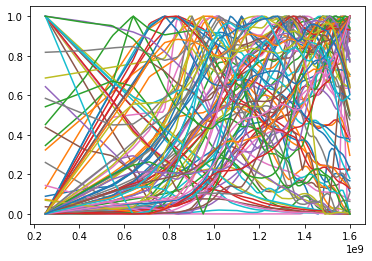

In [39]:
for toc in topics:
  plot_fit(toc, 0.2, lowess_fit, ts_list)


In [ ]:
def get_slopes(fp, yr):
  slopes = []
  for toc in toc_slopes:
    # toc_slopes = {topic: {frac_param: {year: slope}}}
    slope = toc_slopes[toc][fp][yr]
    slopes.append(slope)

  print(slopes)
  print(np.sum(slopes))

In [ ]:
get_slopes("0.1", 1978)


[-1.5585835479923253e-07, 8.007666046275657e-08, 1.8787624903103298e-08, 2.2878605603393256e-08, 5.719720523543507e-07, 5.081782505524478e-10, 2.906040826115834e-09, 3.559440197855734e-08, 1.1403433909935537e-08, 4.470442650206532e-09, 4.339653238866233e-07, 1.2248659900720465e-08, 3.5291523439754113e-07, 7.966509912475904e-08, -6.885449563516242e-09, -3.3689413301720187e-07, 5.238299128650375e-10, -5.015124932035659e-10, 2.0710684494913193e-08, 8.309496778026117e-09, 2.1912522569169244e-08, 0.0, 8.514809828008411e-09, -3.11186378328969e-10, 1.2068593575248495e-09, 3.434126072774559e-08, 4.61736034683397e-07, 3.0023208696777672e-09, 4.606680388152597e-09, 1.3780948534538606e-06, 1.478025828707789e-08, 1.1420140102278845e-08, 1.255612933323106e-07, 3.628658805493787e-07, -4.187018490554766e-09, 1.0999046190035812e-08, 9.229088077809965e-09, -3.074222462742701e-09, -7.778365894277865e-08, -1.595987232101955e-06, -3.0605975474107145e-06, 8.503464593271649e-08, 1.365292512632837e-07, 1.004

In [ ]:
get_slopes("0.1", 1982)

[-1.5585835479913853e-07, 8.00766604627551e-08, 1.8787624903103665e-08, 2.2878605603393256e-08, 5.719720523543566e-07, 5.081782505524536e-10, 2.9060408261154666e-09, 3.559440197855807e-08, 1.1403433909935904e-08, 4.470442650206509e-09, 4.339653238865763e-07, 1.2248659900720465e-08, 3.5291523439754113e-07, 7.966509912475904e-08, -6.885449563516334e-09, -3.3689413301720187e-07, 5.238299128650317e-10, -5.015124932028315e-10, 2.071068449491246e-08, 8.309496778026484e-09, 2.1912522569169333e-08, 0.0, 8.514809828008365e-09, -3.11186378328969e-10, 1.2068593575248036e-09, 3.434126072774632e-08, 4.617360346834029e-07, 3.0023208696777672e-09, 4.606680388152597e-09, 1.3780948534538314e-06, 1.478025828707789e-08, 1.1420140102278478e-08, 1.2556129333231207e-07, 3.6286588054937795e-07, -4.187018490554399e-09, 1.0999046190035812e-08, 9.229088077809965e-09, -3.074222462742701e-09, -7.77836589427669e-08, -1.595987232101955e-06, -3.0605975474107145e-06, 8.503464593271649e-08, 1.365292512632837e-07, 1.00

### Joint analysis of species and country

In [ ]:
ts_unique = documents.Bins_left.unique()
ts_unique.sort()
len(ts_unique), ts_unique

(50,
 array([ 250750799,  425879999,  546839999,  638945999,  712641599,
         778391999,  836193599,  897537599,  949726799,  986961599,
        1018411199, 1046494799, 1072241999, 1099285199, 1123041599,
        1146196799, 1167627599, 1188619199, 1209009599, 1225947599,
        1245729599, 1264136399, 1282622399, 1300161599, 1316145599,
        1332302399, 1347335999, 1362200399, 1375934399, 1389761999,
        1402199999, 1414900799, 1427342399, 1439697599, 1451969999,
        1463716799, 1475899199, 1487393999, 1498967999, 1510376399,
        1521863999, 1532750399, 1543985999, 1554177599, 1564027199,
        1574053199, 1583557199, 1592711999, 1601438399, 1609477200]))

In [ ]:
# PMIDs of Arabidopsis papers from USA
pmid_arabi_usa = cpt_arabi[cpt_arabi["A3"] == "USA"]["PMID"].values
mask           = cpt_arabi["PMID"].isin(pmid_arabi_usa)
corpus         = cpt_arabi[mask]
print(corpus.shape)


(9048, 12)


In [ ]:
dates          = corpus.Date

# Assign new timestamps based on the bin timestamp values
ts_in_bins = []
for date in dates:
  [yr, mo, da] = date.split('-') # year, month, day
  dt   = datetime(int(yr), int(mo), int(da))
  ts   = dt.timestamp()

  bin_idx = bisect(bin_timestamps, ts)

  if bin_idx < len(bin_timestamps):
    ts2     = bin_timestamps[bin_idx]
  # Deal with the last bin
  else:
    ts2     = datetime(2022, 12, 31).timestamp()
  ts_in_bins.append(ts2) 

print(len(ts_in_bins), ts_in_bins[:2])

9048 [836193600, 836193600]


In [ ]:
timestamps = ts_in_bins

# Create a new dataframe with PMID, date, txt_clean, bin, and bin_left
documents = pd.DataFrame({"PMID": corpus['PMID'], "Date": corpus['Date'], 
                          "Timestamps":timestamps})
documents = documents.sort_values("Timestamps")

# a list of tuples showing the bin range (+/-1 of the unique val)
ts_bins   = [pd.Interval(left=ts-1, right=ts+1) for ts in timestamps] 
documents["Bins"]      = ts_bins
documents["Bins_left"] = documents.apply(lambda row: row.Bins.left, 1)
documents.head(2)

,PMID,Date,Timestamps,Bins,Bins_left
29046,24557725,1966-03-01,250750800,"(836193599, 836193601]",836193599
28727,24430772,1972-01-01,250750800,"(836193599, 836193601]",836193599
